# M3: Machine Learning for Computer Vision
## Bag of Visual Words Image Classification part 2

### Table of Contents:
1. SETTING UP
* Descriptors back-end
* Visual Words back-end and intermediate results
* Classifier back-end
2. EXPERIMENTS
* TO BE ADDED: DESCRIPTORS EXPERIMENT
* Tiling experiment
* Histogram scaling (standardScaler) experiment
* SVM experiment
* Fisher Vectors
3. BEST PERFORMING MODEL


# SETTING UP 

In [ ]:
import cv2
import numpy as np
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import plotly.io as pio
from sklearn.svm import SVC
!pip install fishervector
from fishervector import FisherVectorGMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

#pio.renderers.default = "notebook"

# uncomment if optuna is not yet installed
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fishervector: filename=fishervector-0.1-py3-none-any.whl size=3686 sha256=87b79825143c21cfbedaf048be34756516acfc7635c15a906a22aea16b9ecc4e
  Stored in directory: /root/.cache/pip/wheels/81/66/58/f5f7a3ab4198f2e899f7cfadffef8bc51af15a3bcd2f9a08d8
Successfully built fishervector
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 4

We fix the parameters we tested last week to the level with the best performance. Ideally we would have included them again in the experiments, but since this week's tests had very long run times we decided to fix them to the best known value. 

In [ ]:
DES_TYPE_KAZE = 'kaze'
DES_TYPE_SIFT = 'sift'

OPTIONS_PERCENTAGE = [100]
OPTIONS_DES_TYPE = [DES_TYPE_SIFT]
OPTIONS_K = [256]
OPTIONS_KNN_METRIC = ["manhattan"]
OPTIONS_KPT_STEP = [8]
OPTIONS_N_NEIGHBOURS = [29]
IMG_SHAPE = np.array([256, 256])

# settings for the tiling experiments
OPTIONS_H_TILES = [3]
OPTIONS_V_TILES = [1]

# experiments that use a classifier (always svm) except for the SVM experiment where we test 5 kernels
OPTIONS_KERNEL = ['rbf']

# fisher vector experiments
OPTIONS_N_KERNEL = [1,2,6,10]

*Uncomment cell below if running from Google Colab. Change path to folder containing .dat files and the MIT_split folder*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/proj2/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1CfPKITfZP0-nnJQI7Z0Us8zjcsl6f9eS/proj2


In [ ]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

## Descriptors back-end<a name="descriptors"></a> 

In [ ]:
def get_descriptors(trial, X_train):
    """
    Tranforms an array of raw images into an array of descriptors

    Args:
        trial: the optuna trial object
        X_train: array containing the raw images

    Returns:
        train_descriptors: an array containing descriptors
    """

    Train_descriptors = []
    Train_kpt = []

    des_type = trial.suggest_categorical("des_type", OPTIONS_DES_TYPE)
    if des_type == DES_TYPE_KAZE:
        Detector = cv2.KAZE_create(threshold=0.0001)
        percentage = trial.suggest_categorical('percentage', OPTIONS_PERCENTAGE)
    elif des_type == DES_TYPE_SIFT:
        kpt_step = trial.suggest_categorical('kpt_step', OPTIONS_KPT_STEP)
        multiple_scales = trial.suggest_categorical('multiple_scales', [True, False])
        if multiple_scales:
            nr_scales = trial.suggest_categorical('nr_scales', [2, 3, 4])
            kpt_scale_step = trial.suggest_categorical('kpt_scale_step', [4, 8, 16])
        Detector = cv2.SIFT_create()

    for filename in tqdm(X_train, "Computing descriptors", leave=False):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        if des_type == DES_TYPE_KAZE:
            kpt, des = Detector.detectAndCompute(gray, None)
            count = int(len(des) * percentage / 100)
            np.random.seed(0)
            np.random.shuffle(des)
            des = des[0:count]
        elif des_type == DES_TYPE_SIFT:
            kpt = []
            if multiple_scales:
                current_step = kpt_step
                for scale in range(nr_scales):
                    current_kpt = []
                    for x in range(0, gray.shape[1], kpt_step):
                        for y in range(0, gray.shape[0], kpt_step):
                            current_kpt.append(cv2.KeyPoint(x, y, size=current_step))
                    kpt = np.concatenate((kpt, current_kpt))
                    current_step = current_step + kpt_scale_step
            else:
                for x in range(0, gray.shape[1], kpt_step):
                    for y in range(0, gray.shape[0], kpt_step):
                        kpt.append(cv2.KeyPoint(x, y, kpt_step))
            kpt, des = Detector.compute(gray, kpt)
            Train_descriptors.append(des)
            Train_kpt.append(kpt)
    
    return Train_descriptors, Train_kpt

## Visual Words back-end and intermediate results <a name="visual_words"></a>

**Tiling**: this week we try perfroming classification not on histograms based on a whole images, but on a concatenations of sub-histograms, calculated over image patches. Such approach will allow us to preserve some spatial information.

Code below allows us to split image in defined tile-grid:

In [ ]:
def split_in_tiles(img, split_shape):
    """Input shape is H, W, C;
    Retrurn list, where each element is a tile of a spatial piramid
    """
    
    tiles = np.array_split(img, split_shape[0])
    tiles = [np.array_split(stripe, split_shape[1], 1) for stripe in tiles]
    tiles = sum(tiles, [])
    return tiles

<Figure size 432x288 with 0 Axes>

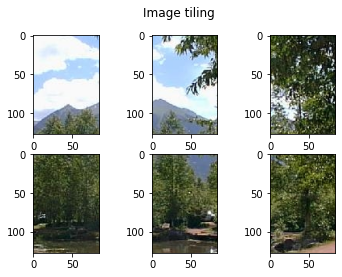

In [ ]:
filename = r"./MIT_split/train/forest/moun46.jpg"
img = cv2.imread(filename)
tiles = split_in_tiles(img,(2, 3))

plt.figure()
f, axarr = plt.subplots(2,3) 


axarr[0][0].imshow(tiles[0][..., ::-1])
axarr[0][1].imshow(tiles[1][..., ::-1])
axarr[0][2].imshow(tiles[2][..., ::-1])
axarr[1][0].imshow(tiles[3][..., ::-1])
axarr[1][1].imshow(tiles[4][..., ::-1])
axarr[1][2].imshow(tiles[5][..., ::-1])

plt.suptitle("Image tiling")
plt.show()

But instead of running keypoint detection/description on each tile, it's more efficient and elegant to make it once for the whole image, and then divide descriptors by their keypoint coordinates, as we do in the code below:

In [ ]:
def split_keypoints(kpt, split_shape, img_shape=None):
    """
    Args:
        kpt: tuple of cv2.KeyPoint
        split_shape: np.ndarray, number of image splits accross each dim
            e.g. (3, 1) will split image into three horizontal stripes,
            and (2, 2) -- into 4 "quadrants" 
        kind: 
            "even" divides image both horizontally and vertically
            "stripes" divides image into horizontal stripes
        img_shape: (H x W) shape of the original image #TODO: infer from keypoints
            if not specified
    
    Returns:
        tiles: array length of kpt, containing indices of keypoints(descriptors)
        in a flattened tiling 
    """
    
    
    #NOTE: kpt's coordinates are x, y (j, i)
    coords = np.array([p.pt for p in kpt])  # array (n_keypoints, 2)
    
    h, w = img_shape
    tile_shape = np.array([
        img_shape[1]/split_shape[1],  # x
        img_shape[0]/split_shape[0],  # y
        ])
    
    # compute to which tile index keypoint belongs to
    tile_indices_2d = np.floor_divide(coords, tile_shape)
    tile_indices_1d = tile_indices_2d[:, 1] * split_shape[1] + tile_indices_2d[:, 0]
    return tile_indices_1d.astype(np.int32)
    

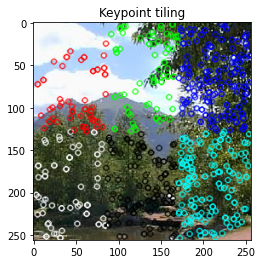

In [ ]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
Detector = cv2.SIFT_create()
kpt, des = Detector.detectAndCompute(gray, None)
tile_indices = split_keypoints(kpt, (2, 3), np.array([256, 256]))
colors = [
    (0, 0, 255),
    (0, 255, 0),
    (255, 0, 0),
    (255, 255, 255),
    (0, 0, 0),
    (255, 255, 0),
]
for keypoint, tile_index in zip(kpt, tile_indices):
    color = colors[tile_index]
    img = cv2.drawKeypoints(img, [keypoint], None, color)

plt.title("Keypoint tiling")
plt.imshow(img[..., ::-1])

In [ ]:
def compute_bags(trial, Train_descriptors, Test_descriptors, Train_kpt, Test_kpt):
    """
    Transforms both the train and test descriptors into two bags of words objects

    Args:
        trial: the optuna trial object
        Train_descriptors: a LIST of arrays, where each array represents an 
            image from the train set with shape (n_detected_keypoints, n_features)
        Test_descriptors: a LIST of arrays, where each array represents an 
            image from the test set with shape (n_detected_keypoints, n_features)

    Returns:
        Return array of shape (n_images, codebook_size)
    """
    
    k = trial.suggest_categorical("k", OPTIONS_K)
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(np.vstack(Train_descriptors))
    
    n_horizontal_tiles = trial.suggest_categorical("n_horizontal_tiles", OPTIONS_H_TILES)
    n_vertical_tiles = trial.suggest_categorical("n_vertical_tiles", OPTIONS_V_TILES)

    tiling_shape = np.array([n_horizontal_tiles, n_vertical_tiles])
    long_k = k * np.prod(tiling_shape)
    
    visual_words=np.zeros((len(Train_descriptors),long_k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        long_hist = []
        tile_indices = split_keypoints(Train_kpt[i], tiling_shape, IMG_SHAPE)
        for tile in np.unique(tile_indices):
            tile_words = words[tile_indices == tile]
            long_hist.append(np.bincount(tile_words, minlength=k))
        visual_words[i,:] = np.concatenate(long_hist)

    visual_words_test=np.zeros((len(Test_descriptors), long_k),dtype=np.float32)
    for i in range(len(Test_descriptors)):
        words=codebook.predict(Test_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        long_hist = []
        tile_indices_test = split_keypoints(Test_kpt[i], tiling_shape, IMG_SHAPE)
        for tile in np.unique(tile_indices_test):
            tile_words = words[tile_indices_test == tile]
            long_hist.append(np.bincount(tile_words, minlength=k))
        visual_words_test[i,:] = np.concatenate(long_hist)
    
  
    return visual_words, visual_words_test

## Classifier back-end<a name="classifier"></a>

This week we use the SVM classifier. To be exact, it is called the SVC for Support Vector Classification. The SVM classifier can use different kernels. We have experimented with the standard kernels rbf, linear, poly and sigma as well as with a precomputed kernel: histogram similarity. To use the histogram similarity we apply the kernel before feeding the data to the SVC. 

In [ ]:
def array_histogram_intersection(hist_train, hist_test):
    kernel_hist_train = np.minimum(hist_train[:, np.newaxis], hist_train).sum(-1)
    kernel_hist_test = np.minimum(hist_test[:, np.newaxis], hist_train).sum(-1)

    return kernel_hist_train, kernel_hist_test


def fit_predict_svm(trial, X_train, y_train, X_test):
    type_kernel = trial.suggest_categorical("type_kernel", OPTIONS_KERNEL)

    if type_kernel == "precomputed":
        svm = SVC(kernel="precomputed")

        kernel_train, kernel_test = array_histogram_intersection(X_train, X_test)

        svm.fit(kernel_train, y_train)    
        pred_test = svm.predict(kernel_test)
    else:
        svm = SVC(kernel=type_kernel)
        svm.fit(X_train, y_train)    
        pred_test = svm.predict(X_test)
    
    return pred_test

# EXPERIMENTS

In the various experiments we use cross validation. Test dataset can't be used for h-param optimization, as it will lead to data leakage, i.e. the model's performance will be influenced by the data outside the Training set. Therefore we use stratified k-fold cross validation splitting of Training set to estimate accuracy during h-param optimization. Stratified means that the folding takes into account the class balance. And we use the Test set only in the end, when we test the best final model.

# Dense sift
Last week we conducted an experiment to investigate the effect of varying scale sizes on the accuracy of a model. Results have indicated the existence of an optimal ratio between the image and keypoint size. [[reference](https://colab.research.google.com/drive/1vDVQvlhicueDQvjLh07TeJVT_-GM2f_o#scrollTo=Ipe0Q1DtAMff)]

This week we have been inspired by [a study on fingerprint-based biometric systems](https://www.researchgate.net/figure/Method-overview-First-dense-SIFT-descriptors-are-computed-at-different-scales-Then_fig1_320991103) which uses a dense sift approach on multiple scales.

The difference being that this week we aggregate multiple scales in order to compute the descriptors.

<Figure size 1080x360 with 0 Axes>

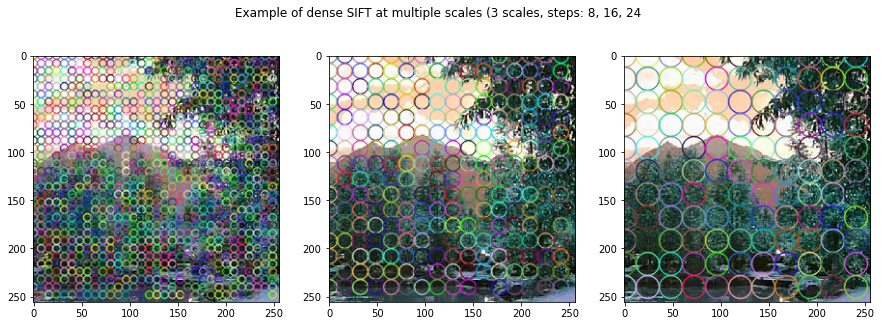

In [ ]:
def draw_multiple_scales_kpts(image, Detector, nr_scales, kpt_step, kpt_scale_step):
    plt.rcParams["figure.figsize"] = (15,5)
    plt.figure()
    fig, ax = plt.subplots(1, 3)
    plt.suptitle('Example of dense SIFT at multiple scales (3 scales, steps: 8, 16, 24')

    current_step = kpt_step
    for scale in range(nr_scales):
        current_kpt = []
        for x in range(0, 256, current_step):
            for y in range(0, 256, current_step):
                current_kpt.append(cv2.KeyPoint(x, y, size=current_step))
        img_keypoints = cv2.drawKeypoints(image, current_kpt, outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        ax[scale].imshow(img_keypoints)
        current_step = current_step + kpt_scale_step
    plt.show()

filename = r"./MIT_split/train/forest/moun46.jpg"
image = cv2.imread(filename)
Detector = cv2.SIFT_create()
kpt = draw_multiple_scales_kpts(image, Detector, 3, 8, 8)

In [ ]:
def objective_desc(trial):
    """
    Calculate mean accuracy across multiple cross-validation folds

    Args:
        trial: the optuna trial object

    Returns:
        accuracy: the objective for each trial
    """

    cumulative_accuracy = 0
    Descriptors, kpt = get_descriptors(trial, train_images_filenames)
    # cast lists above to arrays, so they are accessible through multi-index
    # NOTE: they are not regular "rectangular" arrays, they are object-arrays 
    Descriptors, kpt = np.array(Descriptors), np.array(kpt)
    is_first_fold = True
    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = Descriptors[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = Descriptors[fold[1]], train_labels[fold[1]]
        kpt_train, kpt_validate = kpt[fold[0]], kpt[fold[1]] 
        visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_validate,
                                                                 kpt_train, kpt_validate)
        scaler = StandardScaler()
        visual_words_train = scaler.fit_transform(visual_words_train)
        visual_words_validate = scaler.fit_transform(visual_words_validate)
        pred_validate = fit_predict_svm(trial, visual_words_train, y_train, visual_words_validate) 
        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [ ]:
search_space = {
    "multiple_scales": [True, False],
    "nr_scales": [2, 3, 4],
    "kpt_scale_step": [4, 8, 16]
}
study = optuna.create_study(direction="maximize", study_name='desc_grid', storage='sqlite:///desc.db', load_if_exists=True, sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_desc, n_trials=50)


In [ ]:
optuna.visualization.plot_slice(study)

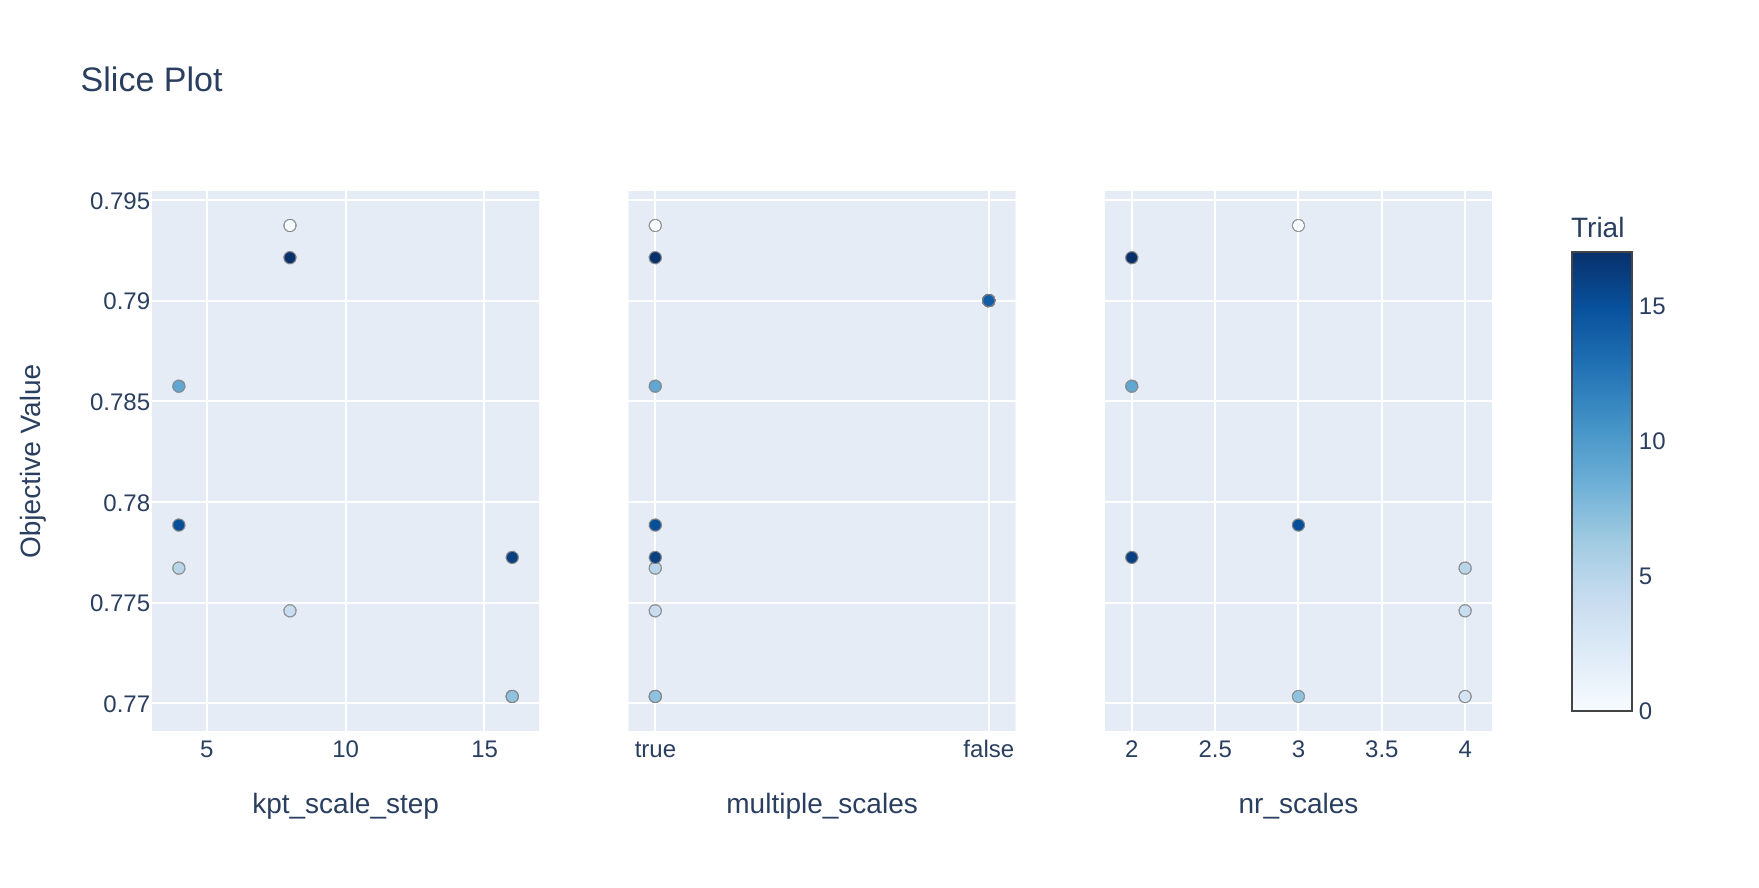

For the first plot, kpt_scale_step represents the step at which we increase at each scale. As it can be seen, the best values come from kpt_scale_step = 8, same as last week for single scale.

From the middle plot above, it can be observed that best accuracy comes from multiscale descriptors. For the single scale case, we have used the best parameters from last week in order to maximize the number of trials spent on multi-scale descriptor.

For the last plot, the best number of scales is shown to be 3, but 2 is a close contender. If computational time/memory was an issue, we could go with 2 scales in order to achieve an accuracy close to the best.

Let's look closer on parameter combinations of this case:


In [ ]:
optuna.visualization.plot_contour(study, params=["nr_scales", "kpt_scale_step"])

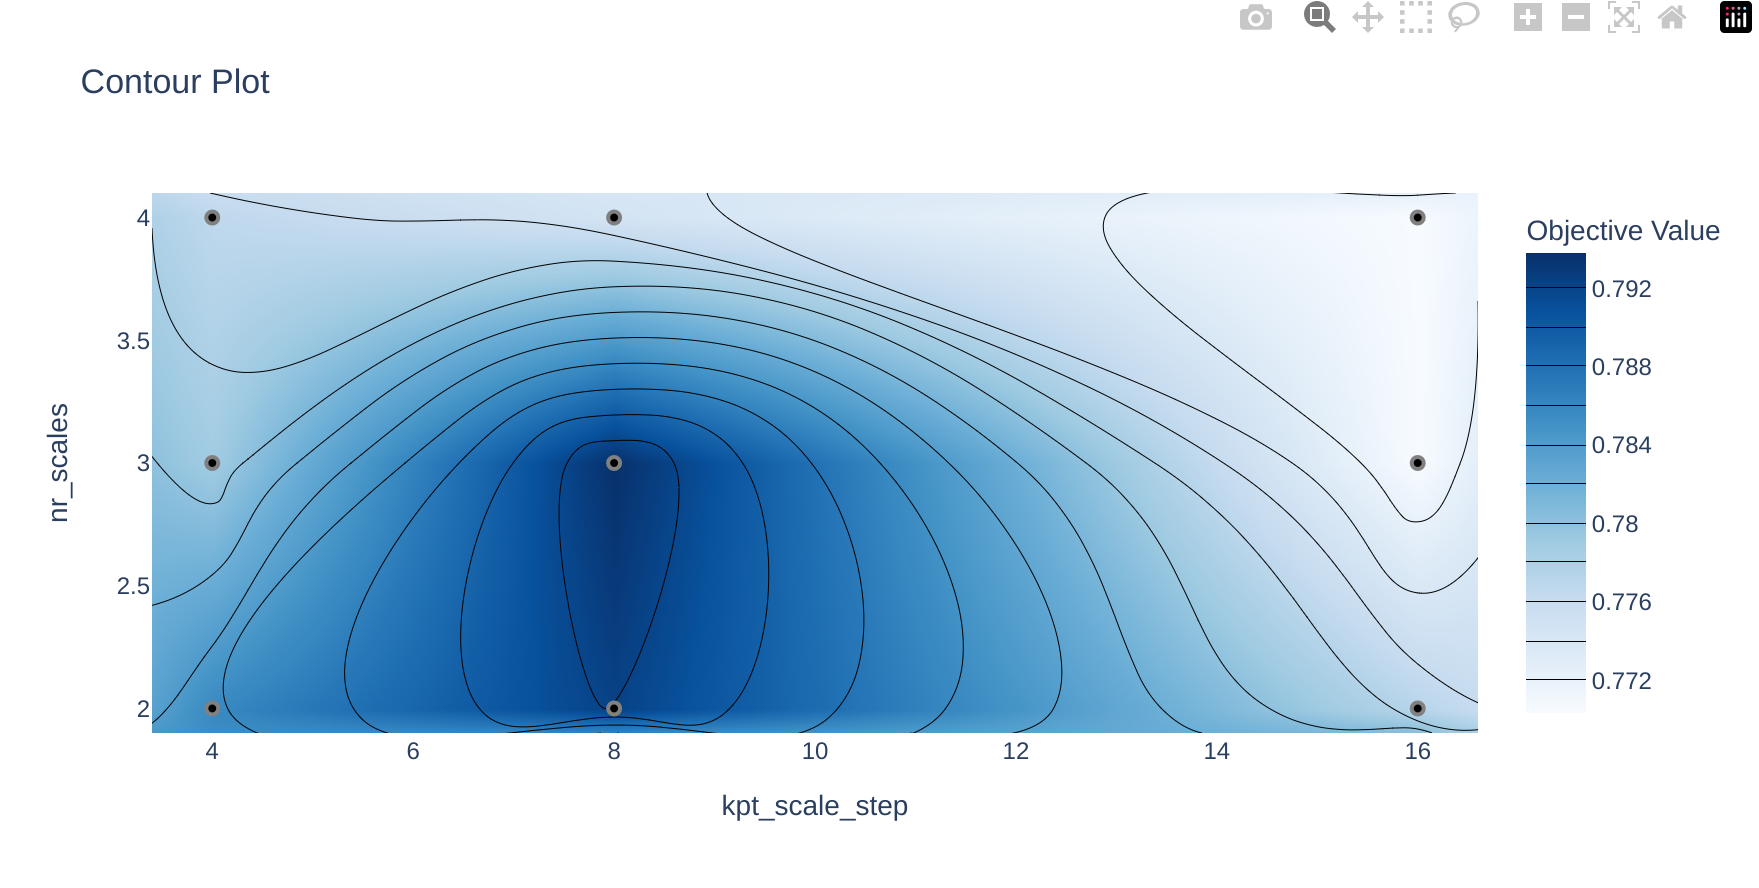

As we see on the chart above, the best combination of descriptor step size and scale step is (8, 3) which leads to Accuracy = 0.7937397708674305. It gives us benefit over no-multiscale-case whose Accuracy is 0.7900121338675998

## Tiling experiment
We try different tiling grids: from 1x1 (which is equal to no tiling at all) to 8x8 which is absurdly detailed tiling into 32x32 image patches. Also, we try asymmetric tiling shapes like 3x1 which means tiling an image into three horizontal stripes.

For the sake of computation speed, other parameters are fixed, and some code of all-params-tuning is rewritten specifically for fast tiling params tuning.

Grid search is used, as we want to estimate all possible tiling shapes.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
folds = list(kf.split(train_images_filenames, train_labels))

In [ ]:
OPTIONS_H_TILES = np.arange(1, 9).tolist()
OPTIONS_V_TILES = np.arange(1, 9).tolist()

OPTIONS_KERNEL = ['rbf']

In [ ]:
# calculate descriptors outside objective functions which don't
# optimize descriptors-related params

Detector = cv2.SIFT_create()
kpt_step = 8

Train_descriptors = []
Train_kpt = []

for filename in tqdm(train_images_filenames, "Computing descriptors", leave=False):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    

    kpt = [cv2.KeyPoint(x, y, kpt_step) for y in range(0, gray.shape[0], kpt_step) 
                            for x in range(0, gray.shape[1], kpt_step)]
    kpt, des = Detector.compute(gray, kpt)
    Train_descriptors.append(des)
    Train_kpt.append(kpt)

Descriptors = np.array(Train_descriptors)
kpt = np.array(Train_kpt)

Computing descriptors:   0%|          | 0/1881 [00:00<?, ?it/s]

In [ ]:
def tiling_objective(trial):
    """
    Calculate mean accuracy across multiple cross-validation folds

    Args:
        trial: the optuna trial object

    Returns:
        accuracy: the objective for each trial
    """

    cumulative_accuracy = 0
    is_first_fold = True
    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = Descriptors[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = Descriptors[fold[1]], train_labels[fold[1]]
        kpt_train, kpt_validate = kpt[fold[0]], kpt[fold[1]] 
        visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_validate,
                                                                 kpt_train, kpt_validate) 
        pred_validate = fit_predict_svm(trial, visual_words_train, y_train, visual_words_validate) 
        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [ ]:
search_space = {
    'n_horizontal_tiles': OPTIONS_H_TILES,
    'n_vertical_tiles': OPTIONS_V_TILES
}

tiling_study = optuna.create_study(direction="maximize", study_name='tiling', storage='sqlite:///tiling.db', load_if_exists=True, sampler=optuna.samplers.GridSampler(search_space))
tiling_study.optimize(tiling_objective, n_trials=8*8)

In [ ]:
fig = optuna.visualization.plot_contour(tiling_study, params=["n_horizontal_tiles", "n_vertical_tiles"])
fig.show()

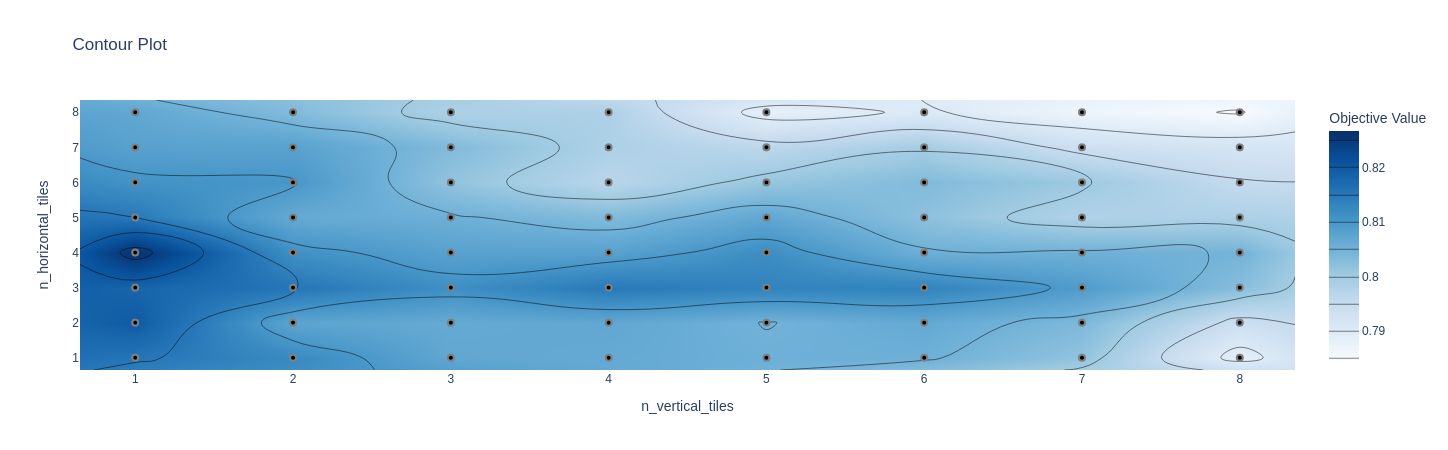

As we see from the results above, splitting into horizontal stripes improve accuracy up to an adequate number of splits, and after 4, it gets worse.

Vertical splitting constantly degrades accuracy (because, usually landscapes have their semantic differences in horizontal stripes), so vertical stripes lead only to generalization downgrade.

The reason behind worse results after certain number of slices is in the fact that too much spatial info lead to lack of generalization.

## Histogram scaling (standardScaler) experiment

In [ ]:
def objective_histogram_normalization(trial):
    """
    Calculate mean accuracy across multiple cross-validation folds

    Args:
        trial: the optuna trial object

    Returns:
        accuracy: the objective for each trial
    """
    trial.params
    cumulative_accuracy = 0
    is_first_fold = True
    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = Descriptors[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = Descriptors[fold[1]], train_labels[fold[1]]
        kpt_train, kpt_validate = kpt[fold[0]], kpt[fold[1]] 
        visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_validate,
                                                                 kpt_train, kpt_validate)
        standardize = trial.suggest_categorical("normalize_hist", [True, False])
        if standardize:
            scaler = StandardScaler()
            visual_words_train = scaler.fit_transform(visual_words_train)
            visual_words_validate = scaler.fit_transform(visual_words_validate)
        # X_train_DR, X_validate_DR = dimensionality_reduction(trial, visual_words_train, y_train, visual_words_validate)
        # pred_validate = fit_predict_classifier(trial, X_train_DR, y_train, X_validate_DR) 
        pred_validate = fit_predict_svm(trial, visual_words_train, y_train, visual_words_validate) 
        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [ ]:
search_space = {
    "normalize_hist": [True, False],
}
study = optuna.create_study(direction="maximize", study_name='normalization', storage='sqlite:///split_nodr.db', load_if_exists=True, sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_histogram_normalization, n_trials=2)


[I 2023-01-15 23:54:41,840] A new study created in RDB with name: normalization


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-01-15 23:57:25,726] Trial 0 finished with value: 0.8309413623793669 and parameters: {'k': 256, 'n_horizontal_tiles': 1, 'n_vertical_tiles': 3, 'normalize_hist': False, 'type_kernel': 'rbf'}. Best is trial 0 with value: 0.8309413623793669.


Fold:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2023-01-16 00:00:18,529] Trial 1 finished with value: 0.8389229076132965 and parameters: {'k': 256, 'n_horizontal_tiles': 1, 'n_vertical_tiles': 3, 'normalize_hist': True, 'type_kernel': 'rbf'}. Best is trial 1 with value: 0.8389229076132965.


In [ ]:
optuna.visualization.plot_slice(study, params=['normalize_hist'])

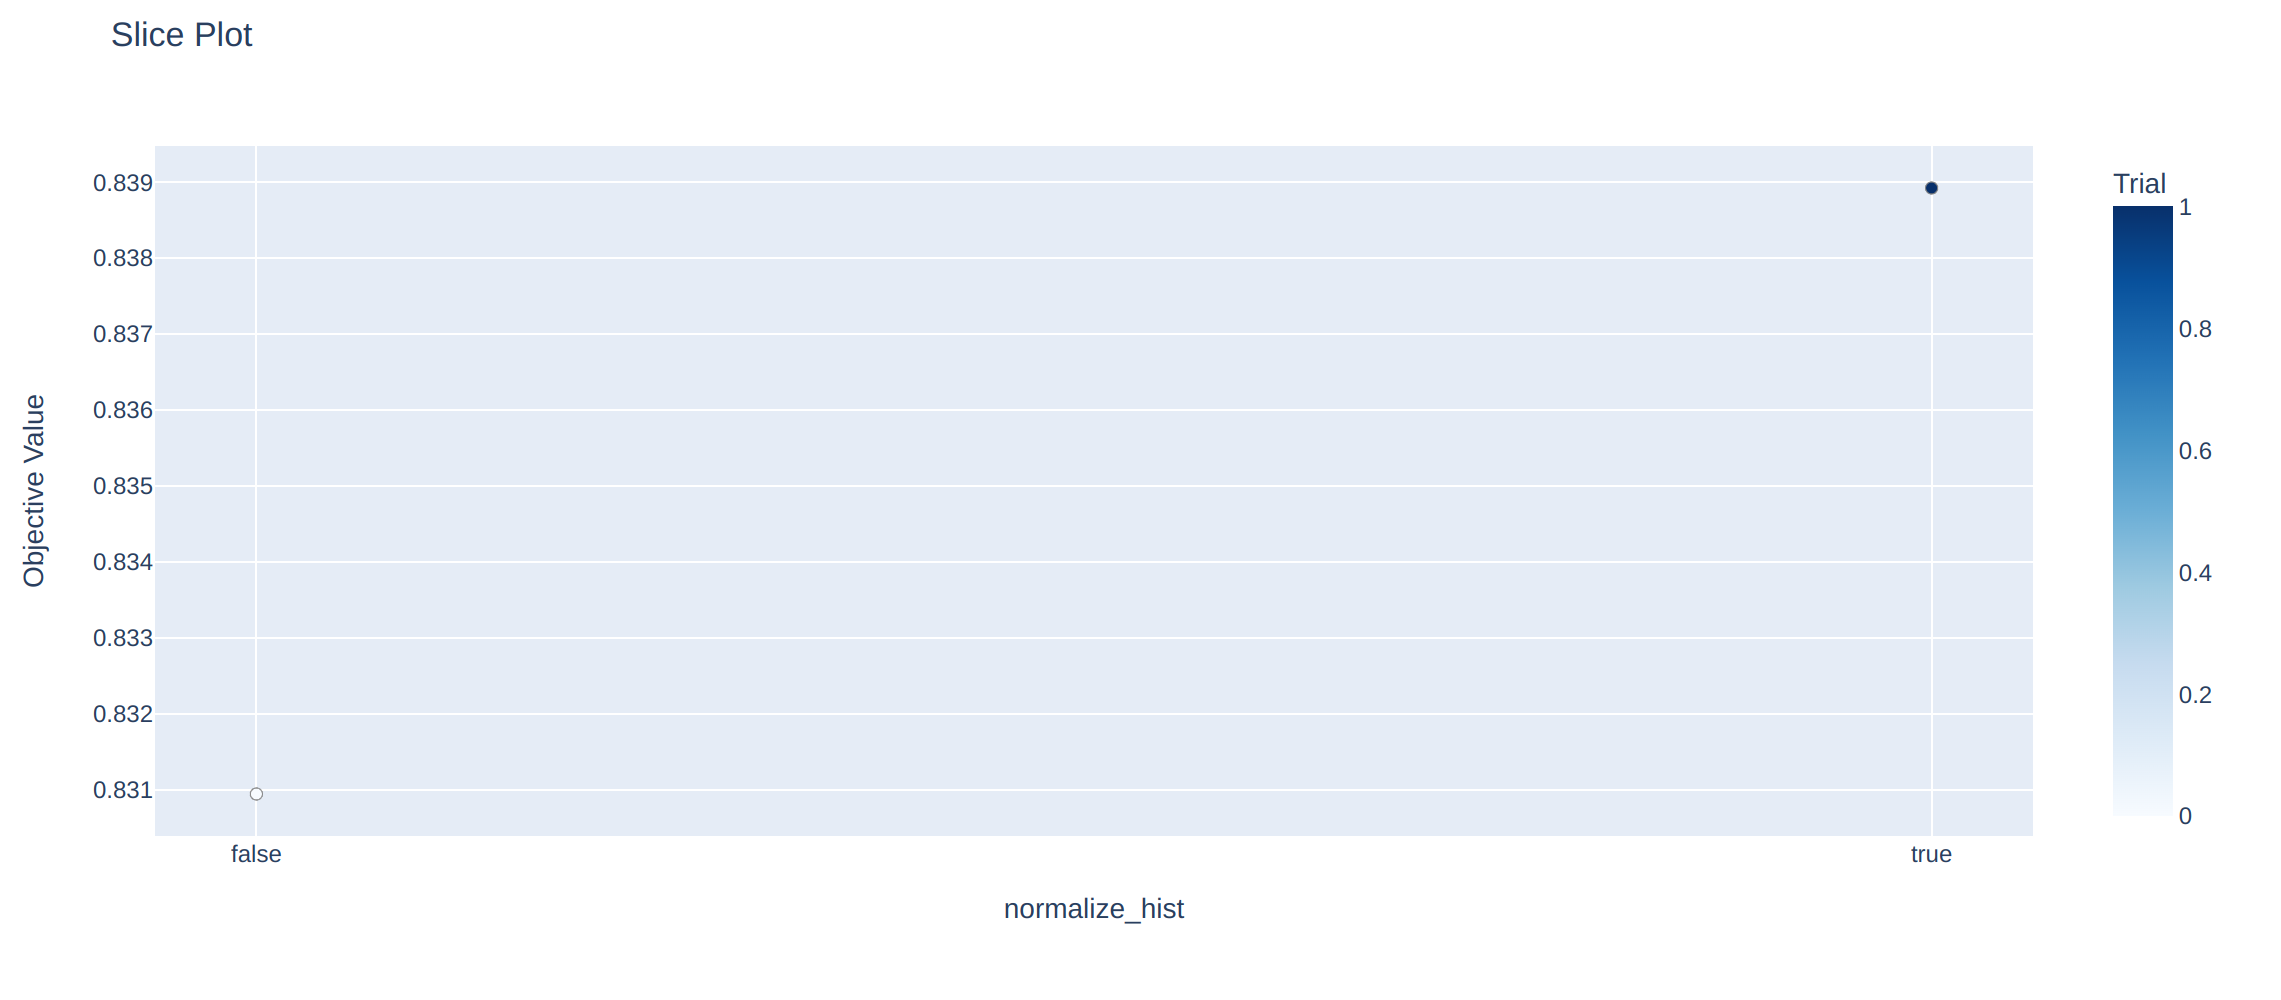

In results above we see the the performance of the classification for two cases: normalized histograms and non-normalized histograms.

On the x-axis we see the two cases and on the y-axis we see the objective value, in this case the accuracy. We find that histogram standardization improves the accuracy of the model. 

## SVM experiment

For the SVM tests we will use the BOW approach as used last week instead of the tiled version. This is due to the fact that the tiled version causes an increase in the number of features which makes the histogram similarity calculations no longer feasible. 

In [ ]:
def get_descriptors(X_train):
    Train_descriptors = []

    Detector = cv2.SIFT_create()

    for filename in tqdm(X_train, "Computing descriptors", leave=False):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        kpt = [cv2.KeyPoint(x, y, kpt_step) for y in range(0, gray.shape[0], kpt_step) 
                                for x in range(0, gray.shape[1], kpt_step)]
        kpt, des = Detector.compute(gray, kpt)
        Train_descriptors.append(des)
    
    return Train_descriptors


def compute_bags(trial, Train_descriptors, Test_descriptors):    
    k = trial.suggest_categorical("k", OPTIONS_K)

    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(np.vstack(Train_descriptors))
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        visual_words[i,:]=np.bincount(words,minlength=k)

    visual_words_test=np.zeros((len(Test_descriptors),k),dtype=np.float32)
    for i in range(len(Test_descriptors)):
        words=codebook.predict(Test_descriptors[i]) # array of labels (quantized/clustered descriptors), they are ints [0;k)
        visual_words_test[i,:]=np.bincount(words,minlength=k)
    
  
    return visual_words, visual_words_test

In [ ]:
OPTIONS_KERNEL = ['rbf', 'linear', 'poly', 'precomputed', 'sigmoid']

In [ ]:
Descriptors = np.array(get_descriptors(train_images_filenames))

In [ ]:
kf = StratifiedKFold(n_splits=2, shuffle=True)
folds = list(kf.split(train_images_filenames, train_labels))

In [ ]:
def svm_objective(trial):
    cumulative_accuracy = 0
    is_first_fold = True
    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = Descriptors[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = Descriptors[fold[1]], train_labels[fold[1]]
        visual_words_train, visual_words_validate = compute_bags(trial, X_train, X_validate) 
        pred_validate = fit_predict_svm(trial, visual_words_train, y_train, visual_words_validate) 
        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score

        # fix trial for following folds. All params must be same accross folds
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [ ]:
svm_study = optuna.create_study(direction="maximize", study_name='svm_kernel_test', storage='sqlite:///svm_kernel_test.db', load_if_exists=True)
svm_study.optimize(svm_objective, n_trials=40) 

In [ ]:
optuna.visualization.plot_slice(svm_study, params=['type_kernel'])

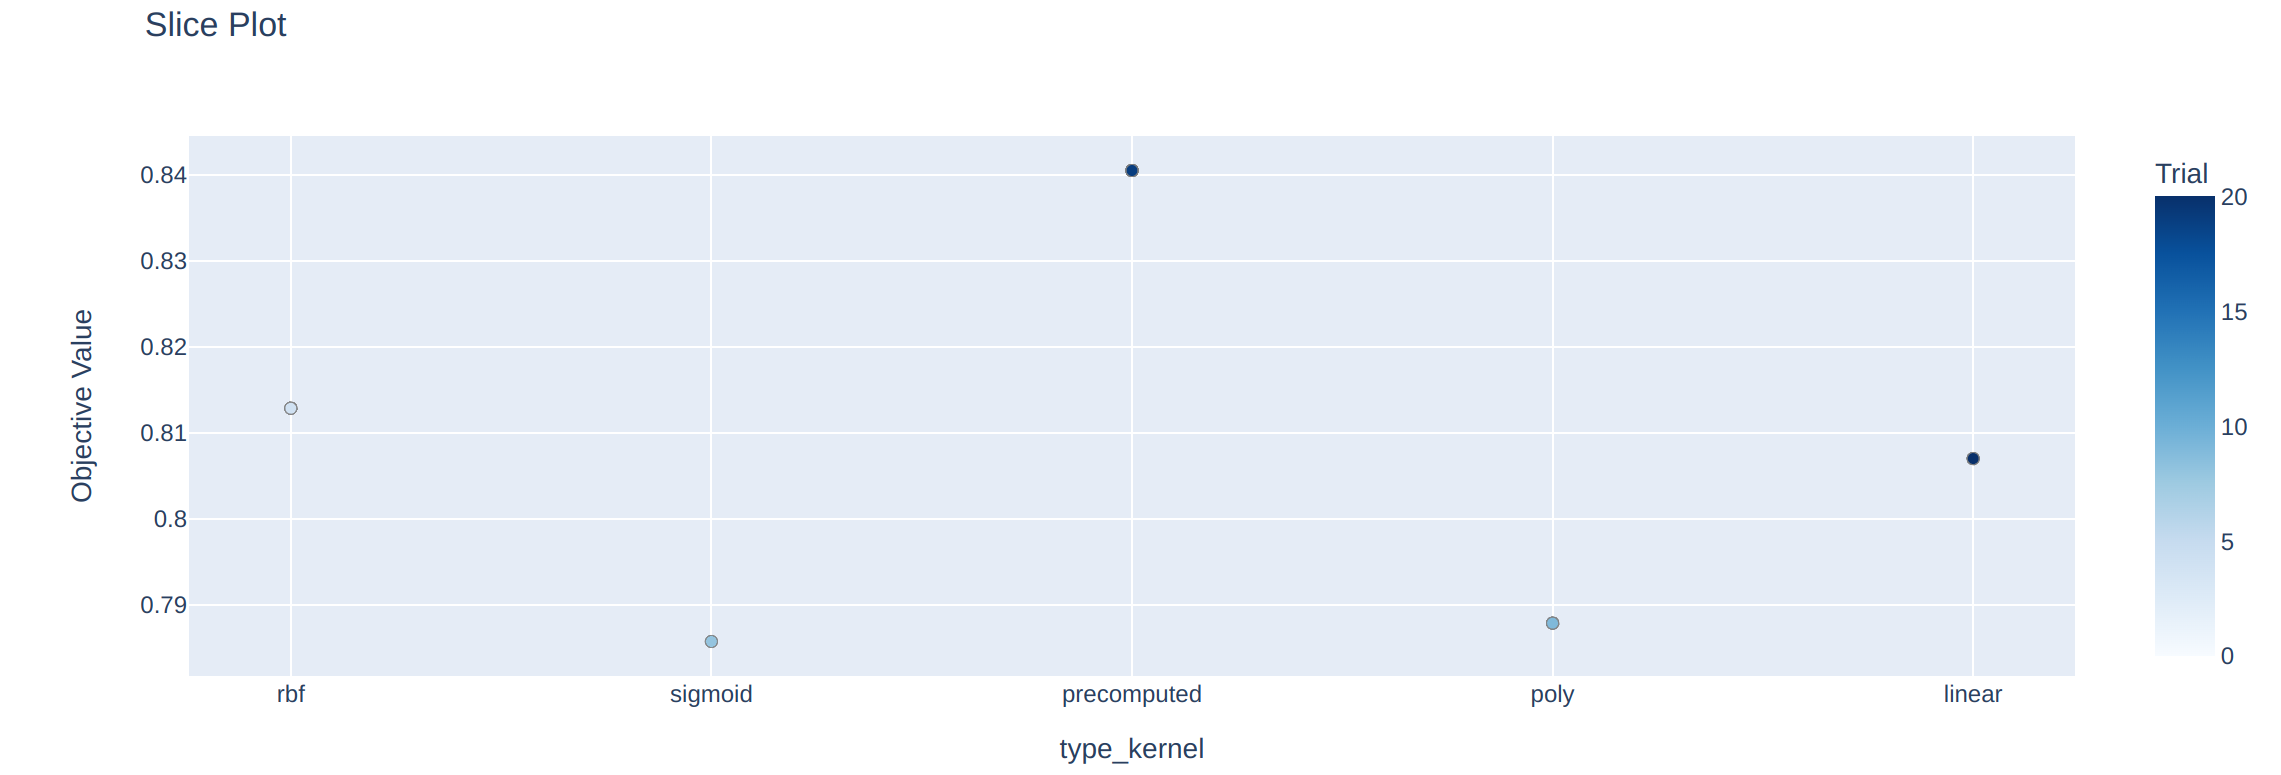

In the plot above you find the results per kernel type. It might look like there were only 5 experiments, but this is due to the fact that there was no randomness in the results, causing the dots to be on top of one another. On the x-axis we see the kernel types and on the y-axis we see the level of the resulting objective value, the accuracy. We see that the precomputed kernel has the best accuracy, followed by the rbf and linear kernels. We thus see that histogram similarity does indeed work well for the BOW data shape. 

## Fisher Vectors

We looked into using fisher vectors instead of BOW. During the experimenting we quickly found out that the calculation of the fisher vectors is very heavy. Initially we wanted to test 5,10,20,50 and 100 kernels. But after trying to run 5 kernels on the whole data set we got a memory error each time. Therefore we decided to use a stratified sub sample of the dataset in order to get some results and intuition about the effectivity of fisher vectors. We used 40 images per class from the train dataset. We then used 3 fold cross-validation for the experiments. We know that k=3 CV is still not very robust but due to time constraints we had no other choice. 

When trying to run the experiments we noticed that n_kernels=20 was taking ages. Considering that it needed to be calculated for 3 folds and we even wanted to get to 50 and 100, we decided to scale down the experiment. In the end we used number of kernels 1,2,6 and 10. We are aware that this is not a very wide range of parameter values, but due to the large space and time complexity of the creation and processing of the fisher vectors it was not feasible to test out more. 

In [ ]:
def compute_bags_fisher(trial, Train_descriptors, Test_descriptors):
    n_kernels = trial.suggest_categorical("n_kernels", OPTIONS_N_KERNEL)

    fv_gmm = FisherVectorGMM(n_kernels=n_kernels).fit(Train_descriptors, )
    fv_train = fv_gmm.predict(Train_descriptors)
    fv_test = fv_gmm.predict(Test_descriptors)

    return fv_train, fv_test

In [ ]:
df_descriptors_train_total = pd.DataFrame()
df_descriptors_train_total['X'] = train_images_filenames
df_descriptors_train_total['y'] = train_labels
df_descriptors_total_train_sampled = df_descriptors_train_total.groupby('y', group_keys=False).apply(lambda x: x.sample(min(len(x), 40)))
train_labels_sampled = list(df_descriptors_total_train_sampled['y'])
train_images_filenames_sampled = df_descriptors_total_train_sampled['X']

df_descriptors_test_total = pd.DataFrame()
df_descriptors_test_total['X'] = test_images_filenames
df_descriptors_test_total['y'] = test_labels
df_descriptors_total_test_sampled = df_descriptors_test_total.groupby('y', group_keys=False).apply(lambda x: x.sample(min(len(x), 20)))
test_labels_sampled = list(df_descriptors_total_test_sampled['y'])
test_images_filenames_sampled = df_descriptors_total_test_sampled['X']

descriptors_train_sampled = np.array(get_descriptors(train_images_filenames_sampled))
descriptors_test_sampled = np.array(get_descriptors(test_images_filenames_sampled))

In [ ]:
kf = StratifiedKFold(n_splits=3, shuffle=True)
folds = list(kf.split(train_images_filenames_sampled, train_labels_sampled))

In [ ]:
def objective_FV(trial):
    cumulative_accuracy = 0
    is_first_fold = True

    for fold in tqdm(folds, "Fold", leave=False):
        X_train, y_train = descriptors_train_sampled[fold[0]], train_labels[fold[0]]
        X_validate, y_validate = descriptors_train_sampled[fold[1]], train_labels[fold[1]]

        res_fisher_train, res_fisher_test = compute_bags_fisher(trial, X_train, X_validate)

        nsamples, nx, ny = res_fisher_train.shape
        d2_train_dataset = res_fisher_train.reshape((nsamples,nx*ny))

        nsamples, nx, ny = res_fisher_test.shape
        d2_test_dataset = res_fisher_test.reshape((nsamples,nx*ny))

        svm = SVC(kernel='rbf')
        svm.fit(d2_train_dataset, y_train)   
        pred_validate = svm.predict(d2_test_dataset)      

        val_score = accuracy_score(y_validate, pred_validate)
        cumulative_accuracy += val_score
        
        if is_first_fold:
            is_first_fold = False
            trial = optuna.trial.FixedTrial(trial.params)

    accuracy = cumulative_accuracy / kf.n_splits

    return accuracy

In [ ]:
FV_study = optuna.create_study(direction="maximize", study_name='testing', storage='sqlite:///proj2_FV.db', load_if_exists=True)
FV_study.optimize(objective_FV, n_trials=20)
#FV_study = optuna.load_study(study_name="testing", storage="sqlite:///proj2_FV.db")

In [ ]:
optuna.visualization.plot_slice(FV_study, params=['n_kernels'])

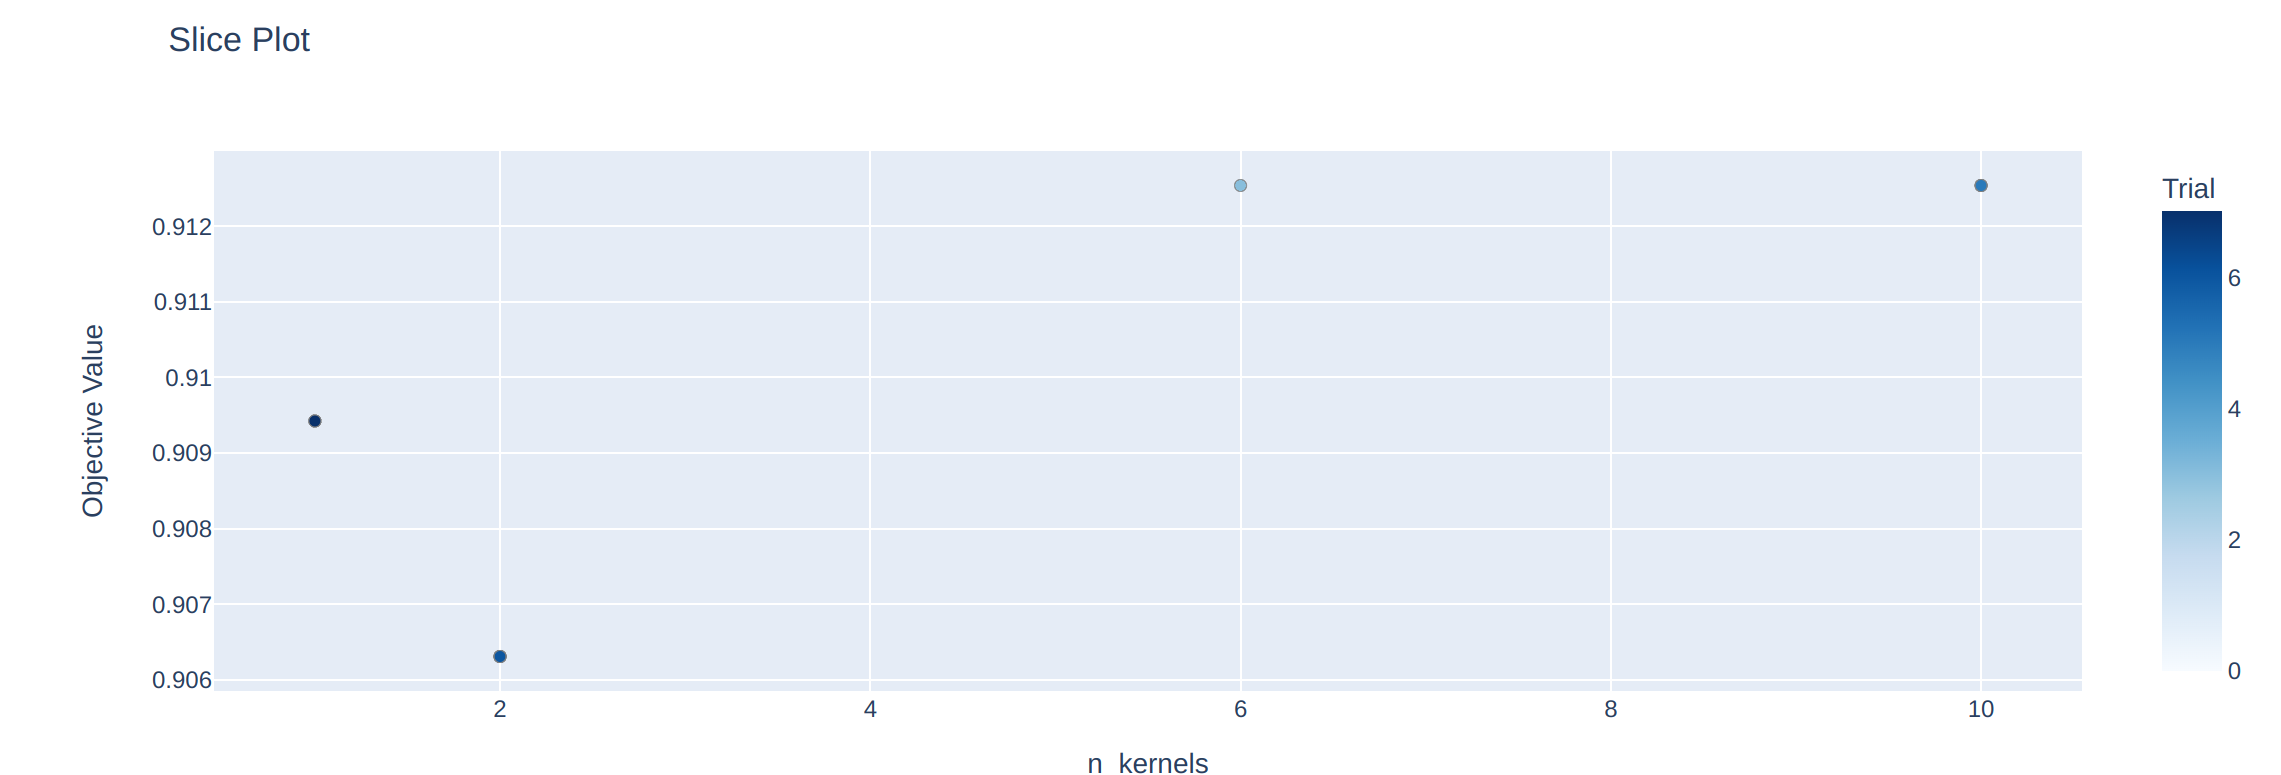

In the plot above we see the accuracy of models trained on fisher vectors with different amounts of kernels. On the x-axis we see the amount of kernels and on the y-axis we see the objective value, which is the accuracy in this case. The model trained on fisher vectors with 10 kernels performs best. Since 10 is the highest tested value and also has the highest accuracy, more experimenting with higher number of kernels would be intersting. But due to the before mentioned high space and time complexity, this was not feasible within this project

# BEST PERFORMING MODEL

The best performing parameters from the experiments were:
```
{PUT BEST PARAMS HERE}
```

In [ ]:
# final_trial = study.best_trial  # create dummy trial
final_trial = optuna.trial.create_trial(value=0)
final_trial.params = {
    "kernel_type": "rbf",
    "n_horizontal_tiles": 3,
    "n_vertical_tiles": 1,
    "des_type": "sift",
    "kpt_scale_step": 8,
    "nr_scales": 3,
    "multiple_scales": True,
    "kpt_step": 8,
    "k": 256,
    "type_kernel": "rbf"

}

In [ ]:
Descriptors, kpt = get_descriptors(final_trial, train_images_filenames)
Descriptors, kpt = np.array(Descriptors), np.array(kpt)

test_Descriptors,test_kpt = get_descriptors(final_trial, test_images_filenames)
test_Descriptors, test_kpt = np.array(test_Descriptors), np.array(test_kpt)

X_train, y_train = Descriptors, train_labels
X_validate, y_validate = test_Descriptors, test_labels
kpt_train, kpt_validate = kpt, test_kpt

In [ ]:
visual_words_train, visual_words_validate = compute_bags(final_trial, X_train, X_validate,
                                                            kpt_train, kpt_validate)

scaler = StandardScaler()
visual_words_train = scaler.fit_transform(visual_words_train)
visual_words_validate = scaler.fit_transform(visual_words_validate)

pred_validate = fit_predict_svm(final_trial, visual_words_train, y_train, visual_words_validate) 

In [ ]:
accuracy = accuracy_score(y_validate, pred_validate)
accuracy

0.8351920693928129

We could achieve slightly better accuracy, but due to the lack of memory with precomputed svm-kernel, we couldn’t train final model without ipython crashing